<a href="https://colab.research.google.com/github/incheonQ/AIFFEL_quest_cr/blob/main/Keras/%5B%EB%AF%BC%EA%B7%9C%5DDefault_Model_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 준비

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 셋업
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import F1Score

In [ ]:

# 데이터셋 만드는 함수
def dataset(direct):
    images=[]
    labels=[]
    classes=[]
    onehot_encoder = OneHotEncoder()

    train_dir = os.listdir(direct)

    for i in train_dir:
        if i == "Train_Test_Valid":
            continue
        if i == '.ipynb_checkpoints':
            continue

        class_path = direct + '/' + i
        classes.append(i)
        for j in os.listdir(class_path):
            file_path = class_path + '/' + j
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (224, 224)) # 입력 이미지 사이즈 224, 224로 수정
                images.append(img)
                labels.append(i)

    images = np.array(images)
    labels = onehot_encoder.fit_transform(np.array(labels).reshape(-1, 1)).toarray()


    return images, labels, classes

In [ ]:
images, labels, classes = dataset('/content/drive/MyDrive/저장소/jellyfish')

In [ ]:
len(images)

4001

In [ ]:
labels[0]

array([1., 0., 0., 0., 0., 0.])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# 데이터 증강

In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_cv

def create_augmentation_pipeline():
    # RandAugment, CutMix, MixUp 설정
    rand_augment = keras_cv.layers.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=3, # 14개의 변환 중 랜덤하게 3개 선택 ✔ 0 석진
        magnitude=0.3              # 변환 강도 ✔
    )
    # cut_mix = keras_cv.layers.CutMix()
    # mix_up = keras_cv.layers.MixUp()

    def augment(images, labels):
        # RandAugment 적용
        images = rand_augment(images)

        # 이미지를 float32로 변환
        images = tf.cast(images, tf.float32)

        # labels를 float32로 변환
        labels = tf.cast(labels, tf.float32)

        # CutMix와 MixUp 적용
        augmented = {"images": images, "labels": labels}
        # augmented = cut_mix(augmented)
        # augmented = mix_up(augmented)

        return augmented["images"], augmented["labels"]

    return augment

batch_size = 512

# 훈련 데이터셋 생성 (augmentation 포함)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset
    .batch(batch_size) # ✔ 1 만순
    .map(create_augmentation_pipeline(), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# 검증 데이터셋 생성
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = (
    val_dataset
    .batch(batch_size) # ✔
    .prefetch(tf.data.AUTOTUNE)
)

# 테스트 데이터셋 생성
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (
    test_dataset
    .batch(batch_size) # ✔
    .prefetch(tf.data.AUTOTUNE)
)

# 모델링

In [ ]:
# 모델 1
from tensorflow.keras.applications import EfficientNetB0

efficient_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=6)
efficient_base_model.trainable = True

efficient_model = keras.models.Sequential()
efficient_model.add(efficient_base_model)
efficient_model.add(keras.layers.GlobalAveragePooling2D())
efficient_model.add(keras.layers.BatchNormalization())
efficient_model.add(keras.layers.Dense(128, activation='relu'))
efficient_model.add(keras.layers.Dense(128, activation='relu'))
efficient_model.add(keras.layers.Dense(128, activation='relu'))
efficient_model.add(keras.layers.Dropout(0.2)) # ✔
efficient_model.add(keras.layers.Dense(6, activation='softmax'))  # 6 output units for classification

custom_adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7) # ✔ 2 은비

efficient_model.compile(loss='categorical_crossentropy', optimizer=custom_adam, metrics=['f1_score']) # ✔

efficient_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,252,457 (16.22 MB)

 Trainable params: 4,207,874 (16.05 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
# 모델 2
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

# Base model setup
efficient_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=6)
efficient_base_model.trainable = True

# Creating sequential model with L1 regularization
efficient_model = keras.models.Sequential()
efficient_model.add(efficient_base_model)
efficient_model.add(keras.layers.GlobalAveragePooling2D())
efficient_model.add(keras.layers.BatchNormalization())
efficient_model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=l1(0.001)))  # Added L1
efficient_model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=l1(0.001)))  # Added L1
efficient_model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=l1(0.001)))  # Added L1
efficient_model.add(keras.layers.Dropout(0.5))
efficient_model.add(keras.layers.Dense(6, activation='softmax'))

# Optimizer and compilation
custom_adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
efficient_model.compile(loss='categorical_crossentropy', optimizer=custom_adam, metrics=['f1_score'])

efficient_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,252,457 (16.22 MB)

 Trainable params: 4,207,874 (16.05 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
# 모델 3
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

# Base model setup
efficient_base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=6)
efficient_base_model.trainable = True

# Creating sequential model with L1 regularization
efficient_model = keras.models.Sequential()
efficient_model.add(efficient_base_model)
efficient_model.add(keras.layers.GlobalAveragePooling2D())
efficient_model.add(keras.layers.BatchNormalization())
efficient_model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=l1(0.001)))  # Added L1
efficient_model.add(keras.layers.Dropout(0.2))
efficient_model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=l1(0.001)))  # Added L1
efficient_model.add(keras.layers.Dropout(0.2))
efficient_model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=l1(0.001)))  # Added L1
efficient_model.add(keras.layers.Dropout(0.5))
efficient_model.add(keras.layers.Dense(6, activation='softmax'))

# Optimizer and compilation
custom_adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
efficient_model.compile(loss='categorical_crossentropy', optimizer=custom_adam, metrics=['f1_score'])

efficient_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2560)                │          10,240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,947,549 (251.57 MB)

 Trainable params: 65,631,702 (250.37 MB)

 Non-trainable params: 315,847 (1.20 MB)

# 모델 학습

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)

In [ ]:
with tf.device('/gpu:0'):
    efficient_history = efficient_model.fit(train_dataset,epochs=100,validation_data=val_dataset,callbacks=[checkpoint,early_stopping, lr_scheduler])

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-52-cb8d4ab46aa4>", line 2, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 145139407736 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_1144993]

# 평가

In [ ]:
test_loss, test_accuracy = efficient_model.evaluate(test_dataset)
print(f"Test Accuracy: {np.mean(test_accuracy)*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - f1_score: 0.9850 - loss: 0.1841
Test Accuracy: 98.70%


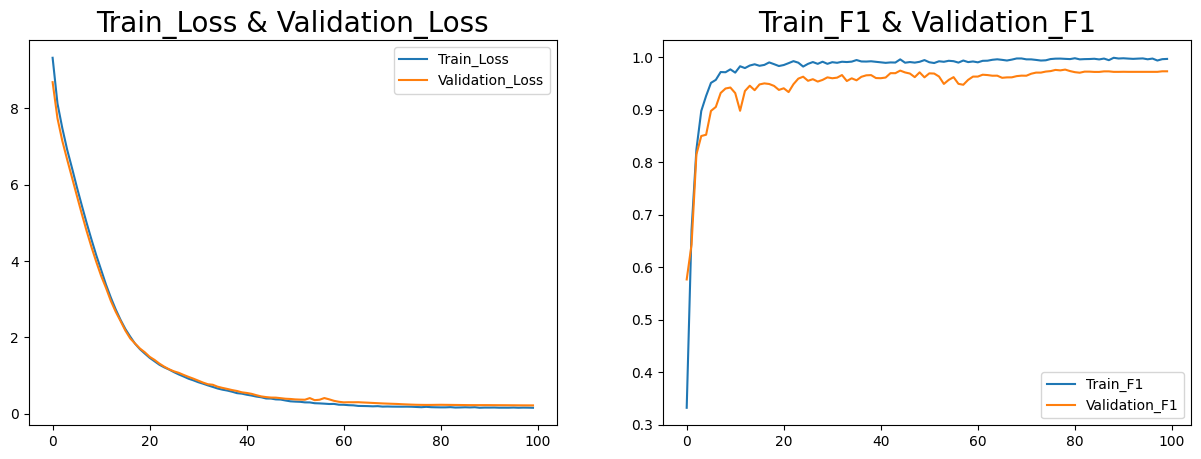

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# If f1_score is a list/array of values per epoch and you need the mean
f1_scores = np.array(efficient_history.history['f1_score']).mean(axis=-1)

# If f1_score is a list/array of values per epoch and you need the mean
val_f1_scores = np.array(efficient_history.history['val_f1_score']).mean(axis=-1)

plt.figure(figsize=(15,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(efficient_history.history['loss'], label='Train_Loss')
plt.plot(efficient_history.history['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()

# F1-score plot
plt.subplot(1,2,2)
plt.plot(f1_scores, label='Train_F1')
plt.plot(val_f1_scores, label='Validation_F1')
plt.title('Train_F1 & Validation_F1', fontsize=20)
plt.legend()

# 모델 저장

In [ ]:
keras.saving.save_model(efficient_model, 'best.h5')

In [ ]:
# 모델 로드
loaded_model = tf.keras.models.load_model('/content/best.h5')

In [ ]:
test_loss, test_accuracy = loaded_model.evaluate(test_dataset)
print(f"Test Accuracy: {np.mean(test_accuracy)*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - f1_score: 0.9850 - loss: 0.1841
Test Accuracy: 98.70%


In [ ]:
loaded_model.optimizer.get_config()

{'name': 'adam',
 'learning_rate': 6.25000029685907e-05,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

# 이어서 학습

In [ ]:
custom_adam = Adam(learning_rate=6.25e-05, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
loaded_model.compile(loss='categorical_crossentropy', optimizer=custom_adam, metrics=['f1_score'])

loaded_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,252,457 (16.22 MB)

 Trainable params: 4,207,874 (16.05 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
loaded_model.fit(train_dataset,epochs=100,validation_data=val_dataset,callbacks=[checkpoint,early_stopping, lr_scheduler])

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 127s 13s/step - f1_score: 0.9958 - loss: 0.1653 - val_f1_score: 0.9720 - val_loss: 0.2278 - learning_rate: 6.2500e-05
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - f1_score: 0.9944 - loss: 0.1686 - val_f1_score: 0.9720 - val_loss: 0.2265 - learning_rate: 6.2500e-05
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - f1_score: 0.9980 - loss: 0.1578 - val_f1_score: 0.9720 - val_loss: 0.2259 - learning_rate: 6.2500e-05
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - f1_score: 0.9978 - loss: 0.1572 - val_f1_score: 0.9720 - val_loss: 0.2251 - learning_rate: 6.2500e-05
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - f1_score: 0.9989 - loss: 0.1589 - val_f1_score: 0.9746 - val_loss: 0.2232 - learning_rate: 6.2500e-05
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - f1_score: 0.9981 - loss: 0.1537 - val_f1_score: 0.9728 - val_loss: 0.2213 - learning_rate: 6.2500e-05
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 601ms/step - f1_score: 0.9926 

In [ ]:
test_loss, test_accuracy = loaded_model.evaluate(test_dataset)
print(f"Test Accuracy: {np.mean(test_accuracy)*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - f1_score: 0.9813 - loss: 0.1736
Test Accuracy: 98.33%
